In [ ]:
# !pip install statsmodels --upgrade
# !pip install pycaret==2.1.2
# !pip install scikit-learn==0.23.2

In [ ]:
import copy

import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import libraries for resampling
import sklearn.neighbors._base

In [ ]:
data_df = pd.read_csv('BankChurners.csv')
data_df.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], 
        axis=1, inplace=True )
data_df.head(5)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### <font color=green>결측치 채우기</font>
참고1) https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 <br>
참고2) https://medium.com/analytics-vidhya/imputing-missing-values-smartly-with-datawig-f2f6b4a07c27

**방법1.** 평균|중앙값|최빈값 <br>
**방법2.** KNN Imputer : 가장 가까운 이웃의 평균값을 사용해서 결측값을 예측. 단, 예측하려는 열 데이터가 아래 1~3중 하나에 해당되어야함. <br>
1) numeric 변수 <br>
2) text->number->encoding까지 적용된 categorical 변수 <br>
3) ordinal 변수 (categorical 변수에 포함되나, 숫자의 증감에 따라 의미가 같이 변하는 변수 ex. 만족도 - 0: 불만족, 1:보통, 2: 만족) <br>
**방법3.** Datawig Simple Imputer: 인공신경망 모델로 결측치 예측. 범주형 변수 예측에 뛰어난 성능을 보임

In [ ]:
catg_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category'] #범주형데이터열

features_with_nan = []

# Unknown이 포함된 열을 알려주는 함수
def hasUnknown(feature): 
    result = 0
    for x in data_df[feature].str.contains('Unknown'):
        if x == True: #
            result = 1
    if result == 1:
        print('{} : has string "Unknown"!'.format(feature))
        features_with_nan.append(feature)

# Unknown문자열이 포함된 셀을 결측치(NaN)로 변형시키는 코드
for feature in catg_features: 
    hasUnknown(feature)
    data_df.loc[data_df[feature] == 'Unknown', feature] = np.nan 

data_df.info()

Education_Level : has string "Unknown"!
Marital_Status : has string "Unknown"!
Income_Category : has string "Unknown"!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             8608 non-null object
Marital_Status              9378 non-null object
Income_Category             9015 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10

In [ ]:
!pip install datawig

In [ ]:
# datawig(딥러닝모델)로 결측치 채우기: [장]범주형변수 결측치 예측에 뛰어난 성능을 보임 [단]오래 걸림...
import datawig

for feature in features_with_nan:
  dtw_train = data_df[data_df[feature].notnull()]
  dtw_test = data_df[data_df[feature].isnull()]
      
  imputer_datawig = datawig.SimpleImputer(
      input_columns=list(data_df.columns.difference(features_with_nan)), # 결측치를 채우기 위해 참고하는 열
      output_column=feature # 채우려는 결측치 열
      )
  
  imputer_datawig.fit(train_df = dtw_train) # num_epochs=50 파라미터 추가 가능
  imputed = imputer_datawig.predict(dtw_test)
  data_df.loc[data_df[feature].isnull(),feature] = imputed['{}_imputed'.format(feature)]

2021-07-22 01:30:55,415 [INFO]  NumExpr defaulting to 2 threads.
2021-07-22 01:30:56,737 [INFO]  
========== start: fit model
2021-07-22 01:30:56,739 [WARNING]  Already bound, ignoring bind()
2021-07-22 01:31:01,911 [INFO]  Epoch[0] Batch [0-243]	Speed: 757.02 samples/sec	cross-entropy=1.547754	Education_Level-accuracy=0.335297
2021-07-22 01:31:07,005 [INFO]  Epoch[0] Train-cross-entropy=1.522612
2021-07-22 01:31:07,011 [INFO]  Epoch[0] Train-Education_Level-accuracy=0.351418
2021-07-22 01:31:07,015 [INFO]  Epoch[0] Time cost=10.264
2021-07-22 01:31:07,025 [INFO]  Saved checkpoint to "education_level/model-0000.params"
2021-07-22 01:31:07,891 [INFO]  Epoch[0] Validation-cross-entropy=1.509402
2021-07-22 01:31:07,901 [INFO]  Epoch[0] Validation-Education_Level-accuracy=0.362269
2021-07-22 01:31:13,051 [INFO]  Epoch[1] Batch [0-243]	Speed: 758.85 samples/sec	cross-entropy=1.522297	Education_Level-accuracy=0.342469
2021-07-22 01:31:18,147 [INFO]  Epoch[1] Train-cross-entropy=1.502672
2021

In [ ]:
data_df.info() # 결측치 채워진 결과

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             10127 non-null object
Marital_Status              10127 non-null object
Income_Category             10127 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10127 non-null float64
Total_Trans_Amt             10127 non-null int64
Total_Trans_Ct              10127 non-null int

In [ ]:
# value_counts : 적절한 분포로 결측치가 채워졌음을 확인
for feature in features_with_nan:
  print(data_df[feature].value_counts())
  print("")

Graduate         4513
High School      2134
Uneducated       1499
College          1014
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

Married     5184
Single      4195
Divorced     748
Name: Marital_Status, dtype: int64

Less than $40K    4291
$40K - $60K       2117
$80K - $120K      1554
$60K - $80K       1416
$120K +            749
Name: Income_Category, dtype: int64



In [ ]:
# index 자동부여 
catg_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
index_dicts = {}
for cat_feature in catg_features:
    data_df[cat_feature] = data_df[cat_feature].astype('category') # category 타입으로 전환. 아래 cat.categories모듈을 쓰기 위해 선행되어야 할 조건.
    idx_list = dict(enumerate(data_df[cat_feature].cat.categories)) 
    print(cat_feature, idx_list)
    index_dicts[cat_feature] = idx_list
index_dicts

Gender {0: 'F', 1: 'M'}
Education_Level {0: 'College', 1: 'Doctorate', 2: 'Graduate', 3: 'High School', 4: 'Post-Graduate', 5: 'Uneducated'}
Marital_Status {0: 'Divorced', 1: 'Married', 2: 'Single'}
Income_Category {0: '$120K +', 1: '$40K - $60K', 2: '$60K - $80K', 3: '$80K - $120K', 4: 'Less than $40K'}
Card_Category {0: 'Blue', 1: 'Gold', 2: 'Platinum', 3: 'Silver'}


{'Card_Category': {0: 'Blue', 1: 'Gold', 2: 'Platinum', 3: 'Silver'},
 'Education_Level': {0: 'College',
  1: 'Doctorate',
  2: 'Graduate',
  3: 'High School',
  4: 'Post-Graduate',
  5: 'Uneducated'},
 'Gender': {0: 'F', 1: 'M'},
 'Income_Category': {0: '$120K +',
  1: '$40K - $60K',
  2: '$60K - $80K',
  3: '$80K - $120K',
  4: 'Less than $40K'},
 'Marital_Status': {0: 'Divorced', 1: 'Married', 2: 'Single'}}

In [ ]:
for cat_feature in catg_features:
    for k,v in index_dicts[cat_feature].items(): # 
        # cat_feature이 Education_Level인 경우 : index_dicts['Education_Level'] == {0: 'College',1:'Doctorate',2:'Graduate',3:'High School',4:'Post-Graduate',5:'Uneducated'}
        # 위에서 key, value를 뽑아와 데이터프레임에 key,value값을 바꿔 저장  ex.'Graduate'값을 가진 셀에 2를 넣어준다 
        data_df[cat_feature].replace(v,k, inplace=True) 

In [ ]:
data_df.to_csv('filled_df.csv')

### <font color=green>Pycaret AutoML 적용</font>

특징) 
- Pycaret은 디폴트로 결측치를 채워줌. numeric variable은 mean, categorical variable은 constant
- setup) normalize = True 설정시, numeric variable를 z스케일링 해줌. categorical variable의 경우 자동으로 one-hot-encoding 적용


In [ ]:
import pandas as pd
data_df_pc = pd.read_csv('filled_df.csv',index_col=0)

In [ ]:
data_df_pc.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Married,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
# y 데이터 변환
data_df_pc.Attrition_Flag = data_df_pc.Attrition_Flag.apply(lambda x: 1 if 'Existing' in x else 0)

In [ ]:
import pycaret
from pycaret.classification import *
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


In [ ]:
data_df_pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [ ]:
setup_clf = setup(data=data_df_pc,
                  target='Attrition_Flag',
                  categorical_features=catg_features,
                  numeric_features=['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon'],
                  session_id=0, normalize= True, # normalize: numeric variable scaler
                  ) # setup으로 초기화 

Setup Succesfully Completed!


,Description,Value
0,session_id,0
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(10127, 20)"
4,Missing Values,False
5,Numeric Features,14
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# 해당 셀 실행 금지 
# !pip install statsmodels --upgrade
# !pip install pycaret==2.1.2
# !pip install scikit-learn==0.23.2

In [ ]:
top5 = compare_models(exclude=['lr'], sort='Accuracy', n_select = 5, fold=5) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.9725,0.9943,0.9901,0.9774,0.9837,0.8951,0.8959,5.4588
1,Light Gradient Boosting Machine,0.9716,0.9938,0.9876,0.9789,0.9832,0.8928,0.8932,0.2670
2,Gradient Boosting Classifier,0.9653,0.9896,0.9904,0.9690,0.9796,0.8648,0.8673,1.9353
3,Extreme Gradient Boosting,0.9637,0.9899,0.9889,0.9686,0.9786,0.8592,0.8614,0.5622
4,Ada Boost Classifier,0.9574,0.9841,0.9795,0.9701,0.9747,0.8385,0.8392,0.5354
5,Random Forest Classifier,0.9448,0.9700,0.9778,0.9574,0.9675,0.7859,0.7879,0.1127
6,Decision Tree Classifier,0.9367,0.8806,0.9632,0.9615,0.9623,0.7640,0.7643,0.0644
7,Extra Trees Classifier,0.9252,0.9707,0.9918,0.9246,0.9570,0.6725,0.6978,0.5573
8,K Neighbors Classifier,0.9076,0.8988,0.9761,0.9188,0.9466,0.6055,0.6215,0.0287
9,Linear Discriminant Analysis,0.9035,0.9179,0.9595,0.9280,0.9435,0.6149,0.6193,0.0558


In [ ]:
# 하이퍼파라미터튜닝 & 모델성능
tuned_CBC = tune_model(top5[0]) # fold: cross validation k값, n_iter: training time -> results in optimized model 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9718,0.9945,0.9899,0.9768,0.9833,0.8924,0.8932
1,0.9704,0.9921,0.9899,0.9752,0.9825,0.8866,0.8877
2,0.9704,0.9912,0.9866,0.9783,0.9824,0.8883,0.8886
3,0.9591,0.9906,0.9866,0.9655,0.9759,0.8411,0.8433
4,0.9774,0.9950,0.9916,0.9817,0.9866,0.9146,0.9150
5,0.9704,0.9941,0.9933,0.9720,0.9825,0.8849,0.8872
6,0.9704,0.9903,0.9866,0.9783,0.9824,0.8883,0.8886
7,0.9732,0.9932,0.9933,0.9752,0.9842,0.8967,0.8983
8,0.9675,0.9918,0.9849,0.9767,0.9808,0.8767,0.8770
9,0.9760,0.9948,0.9899,0.9816,0.9858,0.9095,0.9098


In [ ]:
tuned_LGBM = tune_model(top5[1])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9774,0.9950,0.9899,0.9833,0.9866,0.9152,0.9154
1,0.9746,0.9953,0.9882,0.9816,0.9849,0.9046,0.9048
2,0.9718,0.9916,0.9849,0.9816,0.9832,0.8947,0.8948
3,0.9661,0.9923,0.9849,0.9750,0.9799,0.8718,0.8723
4,0.9774,0.9965,0.9882,0.9849,0.9866,0.9158,0.9158
5,0.9661,0.9931,0.9899,0.9703,0.9800,0.8690,0.8709
6,0.9549,0.9860,0.9832,0.9638,0.9734,0.8253,0.8271
7,0.9647,0.9910,0.9832,0.9750,0.9791,0.8670,0.8673
8,0.9760,0.9945,0.9882,0.9833,0.9858,0.9095,0.9096
9,0.9760,0.9955,0.9882,0.9832,0.9857,0.9102,0.9103


In [ ]:
tuned_GBC = tune_model(top5[2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9563,0.9894,0.9765,0.9716,0.9740,0.8362,0.8363
1,0.9704,0.9908,0.9782,0.9864,0.9823,0.8922,0.8925
2,0.9647,0.9861,0.9798,0.9782,0.9790,0.8689,0.8689
3,0.9506,0.9872,0.9714,0.9698,0.9706,0.8164,0.8164
4,0.9760,0.9924,0.9866,0.9849,0.9857,0.9108,0.9108
5,0.9676,0.9916,0.9899,0.9719,0.9808,0.8749,0.8765
6,0.9605,0.9856,0.9782,0.9749,0.9765,0.8526,0.8527
7,0.9690,0.9920,0.9866,0.9767,0.9816,0.8825,0.8830
8,0.9746,0.9896,0.9832,0.9865,0.9848,0.9059,0.9060
9,0.9732,0.9896,0.9832,0.9848,0.9840,0.9010,0.9010


In [ ]:
tuned_ABC = tune_model(top5[3])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9732,0.9951,0.9882,0.9800,0.9841,0.8989,0.8992
1,0.9774,0.9956,0.9916,0.9817,0.9866,0.9146,0.9150
2,0.9718,0.9937,0.9849,0.9816,0.9832,0.8947,0.8948
3,0.9647,0.9927,0.9832,0.9750,0.9791,0.8670,0.8673
4,0.9817,0.9961,0.9866,0.9916,0.9890,0.9328,0.9329
5,0.9690,0.9928,0.9933,0.9704,0.9817,0.8790,0.8816
6,0.9647,0.9872,0.9882,0.9703,0.9792,0.8640,0.8656
7,0.9690,0.9928,0.9882,0.9751,0.9816,0.8817,0.8825
8,0.9774,0.9945,0.9916,0.9817,0.9866,0.9139,0.9144
9,0.9788,0.9956,0.9882,0.9866,0.9874,0.9213,0.9213


In [ ]:
tuned_RFC = tune_model(top5[4])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9520,0.9875,0.9782,0.9652,0.9716,0.8171,0.8179
1,0.9619,0.9899,0.9866,0.9686,0.9775,0.8532,0.8547
2,0.9549,0.9829,0.9815,0.9653,0.9733,0.8266,0.8278
3,0.9450,0.9744,0.9832,0.9528,0.9677,0.7815,0.7859
4,0.9506,0.9854,0.9748,0.9667,0.9707,0.8138,0.8141
5,0.9506,0.9847,0.9882,0.9545,0.9711,0.8024,0.8081
6,0.9563,0.9834,0.9899,0.9593,0.9744,0.8263,0.8310
7,0.9577,0.9864,0.9866,0.9639,0.9751,0.8350,0.8375
8,0.9605,0.9882,0.9849,0.9686,0.9767,0.8471,0.8484
9,0.9633,0.9902,0.9882,0.9686,0.9783,0.8580,0.8599


#### Model Stacking

In [ ]:
clf1 = setup(data = data_df_pc, target = 'Attrition_Flag',session_id=0, normalize= True)

xgboost = create_model('xgboost')

# stacking으로 쓸 모델들: tuned_LGB, tuned_CBC, tuned_GBC, tuned_EGB, tuned_ABC
# stacking models
stacker = stack_models(estimator_list = [tuned_CBC,tuned_LGBM,tuned_GBC,tuned_ABC,tuned_RFC], meta_model = xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9760,0.9955,0.9882,0.9833,0.9858,0.9102,0.9103
1,0.9774,0.9951,0.9882,0.9849,0.9866,0.9158,0.9158
2,0.9732,0.9880,0.9849,0.9832,0.9840,0.9003,0.9004
3,0.9661,0.9935,0.9849,0.9750,0.9799,0.8718,0.8723
4,0.9803,0.9961,0.9866,0.9899,0.9882,0.9273,0.9274
5,0.9690,0.9937,0.9882,0.9751,0.9816,0.8817,0.8825
6,0.9676,0.9876,0.9866,0.9751,0.9808,0.8767,0.8774
7,0.9732,0.9928,0.9882,0.9800,0.9841,0.8989,0.8992
8,0.9718,0.9942,0.9866,0.9800,0.9832,0.8932,0.8934
9,0.9760,0.9962,0.9865,0.9849,0.9857,0.9108,0.9108


### Resampling

In [ ]:
data_df = pd.read_csv('filled_df.csv',index_col=0)

In [ ]:
x_data = data_df.drop(['Attrition_Flag'], axis=1)
y_data = data_df['Attrition_Flag']

In [ ]:
x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Random Oversampling
over_x_train, over_y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(x_train, y_train)

In [ ]:
categorical_features = ['Card_Category', 'Education_Level', 'Gender', 'Income_Category', 'Marital_Status']
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

temp = list(data_df[data_df.columns.difference(categorical_features)].columns)
temp.remove('Attrition_Flag')

numeric_features = temp
numeric_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

preprocessor_pipe.fit(x_train)

x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

In [ ]:
datasets = [x_train_transformed, over_x_train]

over_x_train = pd.DataFrame(over_x_train)
over_x_train.columns = x_train.columns

for dataset in datasets:
  dataset = pd.DataFrame(dataset)

In [ ]:
x_train_transformed_resample = preprocessor_pipe.transform(over_x_train)
x_test_transformed_resample = preprocessor_pipe.transform(x_test)

### <font color = green>DL Model 적용</font>

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from sklearn import preprocessing

import os
tf.compat.v1.logging
# tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
### y label에 onehotencoding 적용해줄 것 
print(x_train_transformed_resample.shape)
print(over_y_train.shape)
print(x_test_transformed_resample.shape)
print(y_test.shape)

y_test = y_test.reshape(-1,1)
over_y_train = over_y_train.values.reshape(-1,1)
print('===========y data one hot encoding 적용==============')

enc = preprocessing.OneHotEncoder(categories='auto')
train_label = enc.fit_transform(over_y_train).toarray()
test_label = enc.fit_transform(y_test).toarray()
print(x_train_transformed_resample.shape)
print(train_label.shape)
print(x_test_transformed_resample.shape)
print(test_label.shape)

(11834, 34)
(11834,)
(3039, 34)
(3039, 1)
===========y data one hot encoding 적용==============
(11834, 34)
(11834, 2)
(3039, 34)
(3039, 2)


#### <font color=blue>1st_elu_hidden layer3_Dropout</font>

In [ ]:
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(over_y_train).toarray()
test_label = enc.fit_transform(y_test).toarray()

print(train_label.shape)
print(test_label.shape) 


model = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=34, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output



model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])


history = model.fit(x_train_transformed_resample, train_label, batch_size=100, epochs=20, validation_split=0.3,verbose=0) 

result = model.evaluate(x_test_transformed_resample, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

(11834, 2)
(3039, 2)
95/95 [==============================] - 0s 3ms/step - loss: 0.2077 - categorical_accuracy: 0.9398
loss (cross-entropy) : 0.20774881541728973
test accuracy : 0.9397827982902527


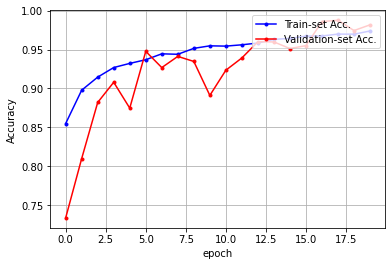

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

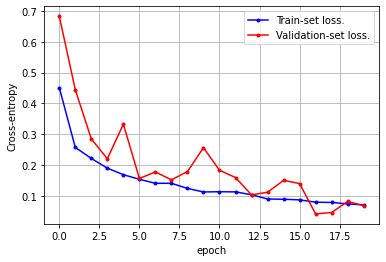

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

#### <font color=blue>2nd_relu_hidden layer1_Dropout</font>

In [ ]:
model_over_relu_R = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model_over_relu_R.add(layers.Dense(input_dim=34, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.BatchNormalization()) # Use this line as if needed
model_over_relu_R.add(layers.Activation('relu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model_over_relu_R.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model_over_relu_R.add(layers.Activation('relu')) 

model_over_relu_R.add(layers.Dropout(rate=0.2)) # Dropout-layer

model_over_relu_R.add(layers.Dense(units=2, activation='softmax')) 

model_over_relu_R.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer, Adam(학습률)
              loss=losses.binary_crossentropy, 
              metrics=[tf.keras.metrics.Recall()])

history_rec = model_over_relu_R.fit(x_train_transformed_resample, train_label, batch_size=10, epochs=20, validation_split=0.3, verbose=0) 

result = model_over_relu_R.evaluate(x_test_transformed_resample, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

95/95 [==============================] - 0s 1ms/step - loss: 0.3720 - recall: 0.9283
loss (cross-entropy) : 0.3719860315322876
test accuracy : 0.9282658696174622


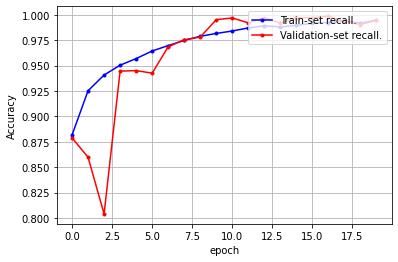

In [ ]:
acc = history_rec.history['recall']
val_acc = history_rec.history['val_recall']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set recall.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set recall.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

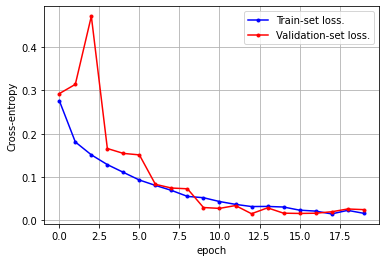

In [ ]:
loss = history_rec.history['loss']
val_loss = history_rec.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

### <font color=green>Keras Tuner (Tuning DL models)</font>

#### Keras Tuner 설치

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras import datasets, Sequential, utils, layers, models, optimizers, losses
# from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

import kerastuner as kt
import numpy as np
import IPython

import copy

import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import libraries for resampling
import sklearn.neighbors._base

In [ ]:
data_df = pd.read_csv('filled_df.csv', index_col=0)
data_df.Attrition_Flag = data_df.Attrition_Flag.apply(lambda x: 1 if 'Existing' in x else 0)
data_df.head(3)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [ ]:
x_data = data_df.drop(['Attrition_Flag'], axis=1)
y_data = data_df['Attrition_Flag']

x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [ ]:
categorical_features = ['Card_Category', 'Education_Level', 'Gender', 'Income_Category', 'Marital_Status']
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

temp = list(data_df[data_df.columns.difference(categorical_features)].columns)
temp.remove('Attrition_Flag')

numeric_features = temp
numeric_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

preprocessor_pipe.fit(x_train)

x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

pd.DataFrame(x_train_transformed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.883937,-0.726172,0.486704,0.890409,0.070596,-0.268854,-1.323300,0.503428,-0.536527,-0.821786,1.414525,0.075773,-0.229879,-0.370894,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.436495,-0.050252,1.383209,-0.428937,0.949128,-1.040993,2.625985,1.512241,0.555353,0.010678,0.127801,0.081877,3.313302,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.596677,0.040598,0.486704,-0.634064,-0.682431,1.275424,-0.335979,-0.379283,0.771925,1.277828,0.771163,-0.417437,0.094497,0.525234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.341046,0.040598,-0.409802,-0.277293,0.196101,0.503285,-1.323300,0.377326,-0.820776,-0.231269,-0.515561,0.705715,-0.037308,-0.072185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.166221,-0.380944,-1.306308,-0.161304,0.321605,1.275424,-1.323300,0.629530,-0.464336,1.171207,-0.515561,0.053798,-0.336732,-0.285549,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,1.643015,-0.784316,0.486704,1.662825,-2.062980,-1.813132,0.651342,-2.018605,0.907282,0.129602,-1.802285,0.227154,2.563568,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7084,-0.411834,-0.460892,0.486704,-0.468994,0.447110,-0.268854,0.651342,0.881733,0.248544,0.035283,0.127801,-0.635963,-0.162949,0.695925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7085,0.156456,-0.384578,-2.202814,0.225399,1.702155,-1.040993,0.651342,1.764445,0.997520,0.818538,0.127801,0.765535,-0.086919,0.098506,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7086,2.813173,-0.835191,-0.409802,2.846484,0.572614,0.503285,0.651342,0.503428,0.013925,0.252626,-0.515561,0.382198,2.863286,2.317490,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
x_train = x_train_transformed.astype('float32')
x_test = x_test_transformed.astype('float32') 

In [ ]:
x_train_transformed.shape

(7088, 34)

In [ ]:
# 2) Build the hyper-model
# Available HyperParameter search spaces (https://j.mp/2IXPzh7) : Int, Float, Boolean, Choice, Fixed

def build_hyper_model(hp):
    
    model = models.Sequential()
    # model.add(layers.Dense(input_dim=34, units=64, activation='relu'))
        
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(10, activation='softmax')) # class 10 : 0~9

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = losses.SparseCategoricalCrossentropy(), # use sparse c.c when our labels are looks like "1" (single integer), not "[1,0,0]" (one-hot vector) (@ http://j.mp/2XS0jmv)
                metrics = ['accuracy'])
    
    return model

In [ ]:
# 3) Select tuner and compile it
# Available tuners (https://j.mp/39cWz4n) : kt.BayesianOptimization / kt.Hyperband / kt.RandomSearch / kt.Sklearn (https://j.mp/3nSJn8O)

tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'MNIST_hyper_1') # Name to use as directory name for files saved by this Tuner

# tuner = kt.Hyperband(build_hyper_model,
#                      objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
#                      max_epochs = 5, # 최대 epoch 수 설정, epoch 수 자체도 지정한 최대 횟수 내에서 변화시켜가며 테스트를 진행함 (epochs to train one model) 
#                      directory = 'test_prac_dir', # Path to the working directory
#                      project_name = 'MNIST_hyper_1') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# 4) Train the model

tuner.search(x_train, y_train, epochs=10, validation_data = (x_test, y_test)) # epochs == learning epoch for training a single model(epoch for each trial) 


# # 아래와 같이 별도의 클래스로 콜백을 정의하여 search 함수에서 활용하면 모든 학습 단계 종료 후 학습 중 발생한 출력 결과를 자동으로 지워낼 수 있습니다.
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

# tuner.search(x_train, y_train, epochs = 7, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()]) # epochs == learning epoch for training a single model 

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.9391247034072876

Best val_accuracy So Far: 0.9457058310508728
Total elapsed time: 00h 01m 28s


In [ ]:
# 5) Check the result 

tuner.results_summary(num_trials=3) # Show "n" best trial results

Results summary
Results in test_prac_dir/MNIST_hyper_1
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 32
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: elu
Score: 0.9457058310508728
Trial summary
Hyperparameters:
num_layers: 3
units_0: 32
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: elu
units_2: 32
activation_2: elu
Score: 0.9450477361679077
Trial summary
Hyperparameters:
num_layers: 3
units_0: 480
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: elu
units_2: 32
activation_2: elu
Score: 0.9440605640411377


In [ ]:
# Check top-3 trials' hyper-params

top3_models = tuner.get_best_hyperparameters(num_trials=3)
# print(tuner.get_best_hyperparameters(num_trials=3)[0].space) # 특정 Trial의 Search-space 를 확인할 수 있음
# print(tuner.get_best_hyperparameters(num_trials=3)[0].values) # 특정 Trial에 적용된 Hyper-params를 확인할 수 있음

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()


# Check the best trial's hyper-params

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'num_layers': 3, 'units_0': 32, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 32, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'elu'}

Model performance rank : 1
{'num_layers': 3, 'units_0': 32, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 32, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'elu'}

Model performance rank : 2
{'num_layers': 3, 'units_0': 480, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 32, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'elu'}


The hyperparameter search is complete. 
* Optimal # of layers : 3
* Optimal value of the learning-rate : 0.01
Layer 0 - # of Perceptrons : 32
Layer 0 - Applied activation function : relu
Layer 1 - # of Perceptrons : 32
Layer 1 - Applied activation function : relu
Layer 2 - # of Perceptrons : 32
Layer 2 - Applied activation function : elu


In [ ]:
# We can retrain the model with the optimal hyperparameters from the search.
best_hps = top3_models[0]

# Build the model with the optimal hyperparameters and train it on the data.
model = tuner.hypermodel.build(best_hps)
model.fit(x_train_transformed, y_train, epochs=10, validation_data=(x_test_transformed, y_test))

results = model.evaluate(x_test, y_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Epoch 1/10
222/222 [==============================] - 1s 3ms/step - loss: 0.2767 - accuracy: 0.8962 - val_loss: 0.1876 - val_accuracy: 0.9240
Epoch 2/10
222/222 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.9276 - val_loss: 0.1635 - val_accuracy: 0.9325
Epoch 3/10
222/222 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.9374 - val_loss: 0.1721 - val_accuracy: 0.9322
Epoch 4/10
222/222 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9444 - val_loss: 0.1623 - val_accuracy: 0.9306
Epoch 5/10
222/222 [==============================] - 1s 2ms/step - loss: 0.1260 - accuracy: 0.9498 - val_loss: 0.1640 - val_accuracy: 0.9362
Epoch 6/10
222/222 [==============================] - 1s 2ms/step - loss: 0.1239 - accuracy: 0.9517 - val_loss: 0.1543 - val_accuracy: 0.9385
Epoch 7/10
222/222 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9547 - val_loss: 0.1565 - val_accuracy: 0.9375
Epoch 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,562
Trainable params: 3,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We can also find detailed logs, checkpoints, etc, in the folder "directory/project_name".

# The [test_prac_dir/MNIST_hyper_1] directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. 
# If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
# To disable this behavior, pass an additional [overwrite = True] argument while instantiating the tuner.

for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

# tuner.oracle.trials -> get all trial_id 

Trial-score is : 0.9457058310508728
Trial-directory(trial_id) is : 088c73da9987b0855eb0a8f8b6e70a5c

Trial-score is : 0.9450477361679077
Trial-directory(trial_id) is : 19e46849bff1aff81835ab78fffb387e

Trial-score is : 0.9440605640411377
Trial-directory(trial_id) is : 5f493d8c22b0f4831394bdc7a21ee636

